In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_PROCESSED, 'static_cluster_lagged.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos

In [2]:
static_data = pd.read_pickle(STATIC_DATASET_PATH)
print(static_data.shape)
static_data.head()

(76277, 132)


,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,difficulty_7.0_success_ratio,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I should modify the fill_profits function from the preprocessing module. As I will be only adding a column, that shouldn't affect the old code (I could add a boolean in the signature if anything goes wrong). Let's use the old functions to get the data needed.

We have to differentiate the case when the customer has viewed an offer in the last 10 days, from the case in which it hasn't.

In [3]:
static_data.viewed.mean()

0.7502523696527131

So, 75% of the sent offers are seen.

In [4]:
# Read the data
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic Preprocessing
print('Basic preprocessing')
%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

Basic preprocessing
CPU times: user 3.25 s, sys: 204 ms, total: 3.45 s
Wall time: 2.21 s


In [5]:
print(data.shape)
data.head()

(306534, 20)


,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,1,17382,20.0,10.0,discount,5.0,0.0,0.0,1.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,0.0,1.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [6]:
data.person.nunique()

17000

In [7]:
data.time.nunique()

120

In [8]:
received, viewed, completed, transactions = pp.split_transcript(data)

In [9]:
transactions.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,20.0,2016-07-11,F,30000.0,0,16993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,42.0,2016-01-17,M,96000.0,0,16817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,36.0,2017-12-28,M,56000.0,0,17528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,55.0,2017-10-16,F,94000.0,0,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,39.0,2017-12-17,F,67000.0,0,17517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Create empty time series
ts = pd.DataFrame(np.zeros((data.time.nunique(), data.person.nunique())), 
                  index=data.time.unique(), columns=data.person.unique())

ts.update(transactions.pivot_table(index='time',
                              columns='person',
                              values='amount',
                              aggfunc='sum'))

print(ts.shape)
ts.head()

(120, 17000)


,78afa995795e4d85b5d9ceeca43f5fef,a03223e636434f42ac4c3df47e8bac43,e2127556f4f64592b11af22de27a7932,8ec6ce2a7e7949b1bf142def7d0e0586,68617ca6246f4fbc85e91a2a49552598,389bc3fa690240e798340f5a15918d5c,c4863c7985cf408faee930f111475da3,2eeac8d8feae4a8cad5a6af0499a211d,aa4862eba776480b8bb9c68455b8c2e1,31dda685af34476cad5bc968bdb01c53,...,22617705eec442e0b7b43e5c5f56fb17,fc966e9c3edc4578a1fb4c6a8c2659c2,47683732768a4f7db7abb710ca22e66e,3873fe915496482eb589fa316ae7b0db,8578196a074a4f328976e334fa9383a3,9fcbff4f8d7241faa4ab8a9d19c8a812,ebae5093b436466c9fbd097cb7434023,912b9f623b9e4b4eb99b6dc919f09a93,3045af4e98794a04a5542d3eac939b1f,da7a7c0dcfcb41a8acc7864a53cf60fb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ts.sum().head()

78afa995795e4d85b5d9ceeca43f5fef    159.27
a03223e636434f42ac4c3df47e8bac43      4.65
e2127556f4f64592b11af22de27a7932     57.73
8ec6ce2a7e7949b1bf142def7d0e0586      0.00
68617ca6246f4fbc85e91a2a49552598      0.24
dtype: float64

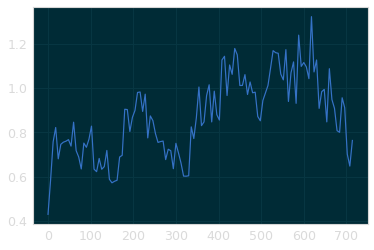

In [12]:
ts.mean(axis=1).plot()

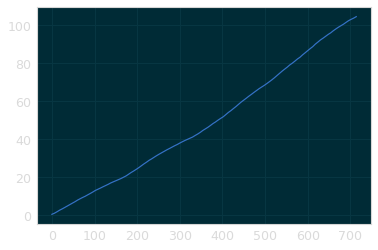

In [13]:
ts.cumsum().mean(axis=1).plot()

In [14]:
sending_times = received.time.unique()
sending_times

array([  0, 168, 336, 408, 504, 576])

In [15]:
sending_times[1:] - sending_times[:-1]

array([168, 168,  72,  96,  72])

In [16]:
168/24

7.0

Let's assume that the period of interest for an offer is always 10 days after it was received. Let's make a table that shows if an offer was received in the past 10 days.

In [17]:
received.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,1,17382,20.0,10.0,discount,5.0,0.0,0.0,1.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,0.0,1.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [18]:
user = received[received.person == received.person[0]]
user

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1.0
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,75.0,2017-05-09,F,100000.0,0,17295,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
150598,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,75.0,2017-05-09,F,100000.0,0,17295,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0
201572,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0


In [19]:
offers = portfolio.id.values

In [20]:
offer_ts = pd.DataFrame(np.zeros((data.time.nunique(), len(offers))),
                        index=data.time.unique(), columns=offers)
offer_ts.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
delta = 24 * 10
for i, row in user.iterrows():
    offer_ts.loc[row.time: row.time + delta, row.offer_id] = 1

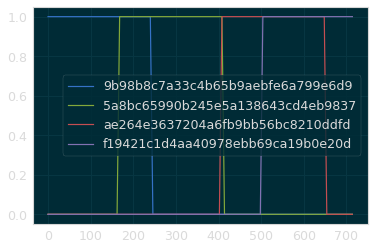

In [22]:
offer_ts.loc[:, user.offer_id].plot()

In [23]:
def get_offers_ts(user_received, portfolio, data, delta = 24 * 10, viewed=False):
    """ 
    Given the received sequence for a user, this function returns a time series
    dataframe containing a 1 in a 10 days period after receiving an offer.
    It can filter out the non-viewed offers.
    Args:
        user_received(dataframe): The received offers for one user.
        portfolio(dataframe): The original portfolio of offers (just to get the offer ids).
        data(dataframe): The original transcript (just to get the time values).
        delta(int): The period of relevance for an offer.
        viewed(boolean): Whether to show only the offers that were viewed.
    """
    offers = portfolio.id.values
    offer_ts = pd.DataFrame(np.zeros((data.time.nunique(), len(offers))),
                            index=data.time.unique(), columns=offers)
    for i, row in user_received.iterrows():
        if viewed:
            if row.viewed:
                offer_ts.loc[row.time: row.time + delta, row.offer_id] = 1
        else:
            offer_ts.loc[row.time: row.time + delta, row.offer_id] = 1
    # Fill the "no-offer" column
    offer_ts['no_offer'] = (offer_ts.sum(axis=1) == 0).astype(int)
    return offer_ts

Let's plot the offers' relevant periods considering all the offers received and only those that were viewed.

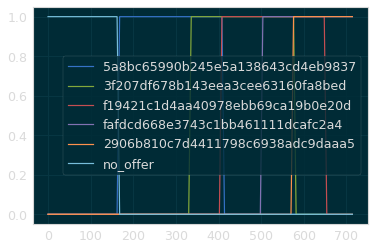

In [24]:
user = static_data[static_data.person == static_data.person[1]]
interesting_offers = user.offer_id.tolist() + ['no_offer']
offer_times = get_offers_ts(user, portfolio, data, viewed=False)
offer_times.loc[:, interesting_offers].plot()

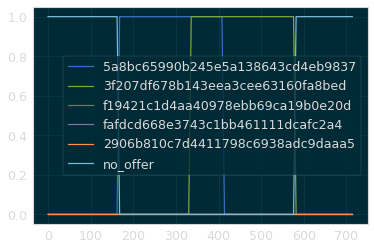

In [25]:
get_offers_ts(user, portfolio, data, viewed=True).loc[:, interesting_offers].plot()

There is overlap. Let's see if the offers, in mean, behave similarly in their full period of interest. If that is true, a model could be implemented on a day-to-day basis, and the overlapping zones could be ignored, or taken into account in an easier way.

In [26]:
transactions.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,20.0,2016-07-11,F,30000.0,0,16993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,42.0,2016-01-17,M,96000.0,0,16817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,36.0,2017-12-28,M,56000.0,0,17528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,55.0,2017-10-16,F,94000.0,0,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,39.0,2017-12-17,F,67000.0,0,17517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
offer = portfolio.id[0]
offer

'ae264e3637204a6fb9bb56bc8210ddfd'

In [28]:
# Create empty time series
ts = pd.DataFrame(np.zeros((data.time.nunique(), data.person.nunique())), 
                  index=data.time.unique(), columns=data.person.unique())

ts.update(transactions.pivot_table(index='time',
                              columns='person',
                              values='amount',
                              aggfunc='sum'))

In [29]:
ts.shape

(120, 17000)

In [30]:
static_data.shape

(76277, 132)

In [31]:
%time multi_offer_times = static_data.groupby('person').apply(lambda x: get_offers_ts(x, portfolio, data, viewed=False).stack() )

CPU times: user 1min 59s, sys: 516 ms, total: 2min
Wall time: 2min


In [32]:
multi_offer_times.shape

(16994, 1320)

In [33]:
portfolio.shape

(10, 9)

In [34]:
120 * 11

1320

In [35]:
multi_offer_times.head()

0    \
                                 ae264e3637204a6fb9bb56bc8210ddfd   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 4d5c57ea9a6940dd891ad53e9dbe8da0   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 3f207df678b143eea3cee63160fa8bed   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              1.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 0b1e1539f2cc45b7b9fa7c272da2e1d7   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 2298d6c36e964ae4a3e7e9706d1fb8c2   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              0.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 fafdcd668e3743c1bb461111dcafc2a4   
person                                                              
0009655768c64bdeb2e877511632db8f                              0.0   
00116118485d4dfda04fdbaba9a87b5c                              0.0   
0011e0d4e6b944f998e987f904e8c1e5                              0.0   
0020c2b971eb4e9188eac86d93036a77                              1.0   
0020ccbbb6d84e358d3414a3ff76cffd                              0.0   

                                                                   \
                                 5a8bc65990b245e5a138643cd4eb9837   
person                                               

In [36]:
offer_times = get_offers_ts(user, portfolio, data, viewed=False)
offer_times.stack()

0    ae264e3637204a6fb9bb56bc8210ddfd    0.0
     4d5c57ea9a6940dd891ad53e9dbe8da0    0.0
     3f207df678b143eea3cee63160fa8bed    0.0
     9b98b8c7a33c4b65b9aebfe6a799e6d9    0.0
     0b1e1539f2cc45b7b9fa7c272da2e1d7    0.0
     2298d6c36e964ae4a3e7e9706d1fb8c2    0.0
     fafdcd668e3743c1bb461111dcafc2a4    0.0
     5a8bc65990b245e5a138643cd4eb9837    0.0
     f19421c1d4aa40978ebb69ca19b0e20d    0.0
     2906b810c7d4411798c6938adc9daaa5    0.0
     no_offer                            1.0
6    ae264e3637204a6fb9bb56bc8210ddfd    0.0
     4d5c57ea9a6940dd891ad53e9dbe8da0    0.0
     3f207df678b143eea3cee63160fa8bed    0.0
     9b98b8c7a33c4b65b9aebfe6a799e6d9    0.0
     0b1e1539f2cc45b7b9fa7c272da2e1d7    0.0
     2298d6c36e964ae4a3e7e9706d1fb8c2    0.0
     fafdcd668e3743c1bb461111dcafc2a4    0.0
     5a8bc65990b245e5a138643cd4eb9837    0.0
     f19421c1d4aa40978ebb69ca19b0e20d    0.0
     2906b810c7d4411798c6938adc9daaa5    0.0
     no_offer                            1.0
12   ae264

## 1) Let's get the spent money in 10 days from the offer reception, without taking into account the overlapping or the views.

In [37]:
# Get the data
static_data = pd.read_pickle(STATIC_DATASET_PATH)
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)
received, viewed, completed, transactions = pp.split_transcript(data)

CPU times: user 3.45 s, sys: 16 ms, total: 3.47 s
Wall time: 2.31 s


In [38]:
static_data.shape

(76277, 132)

In [39]:
transactions.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_mobile,channel_social,channel_email,channel_web
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,20.0,2016-07-11,F,30000.0,0,16993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,42.0,2016-01-17,M,96000.0,0,16817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,36.0,2017-12-28,M,56000.0,0,17528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,55.0,2017-10-16,F,94000.0,0,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,39.0,2017-12-17,F,67000.0,0,17517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
from tqdm import tqdm

In [41]:
# TODO: Make a function out of the code below...

In [42]:
def get_spent_days_static(static_data, preprocessed_data, days=10*24):
    """
    Get a static data version of the profit N days dataset.
    Calculates the total money spent for each customer, in the 10 days after
    an offer is shown.
    Args:
        static_data(dataframe): The 'offer success' version of the static data.
        preprocessed_data(dataframe): the result of 'basic_preprocessing'.
        days(int): The number of days to calculate the profits.
    """
    received, viewed, completed, transactions = pp.split_transcript(preprocessed_data)
    
    results = list()
    for idx, row in tqdm(list(static_data.iterrows())):
        record = dict()
    
        # Id of the record
        record['person'] = row.person
        record['time'] = row.time
        record['offer_id'] = row.offer_id
    
        record['spent_10_days'] = transactions[(transactions.person == row.person) &
                                               (transactions.time > row.time) &
                                               (transactions.time <= row.time + days)
                                              ].amount.sum()
        results.append(record)
    
    return static_data.merge(pd.DataFrame(results), 
                             on=['person', 'time', 'offer_id'], how='left')

In [ ]:
filled = get_spent_days_static(static_data, data)

 37%|███▋      | 28519/76277 [08:26<14:24, 55.22it/s]

In [ ]:
print(filled.shape)
filled.head()

In [ ]:
filled.spent_10_days.sum()

In [ ]:
filled.to_pickle(os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'))

In [ ]:
filled = pd.read_pickle(os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'))

In [ ]:
filled.groupby('offer_id').spent_10_days.sum().sort_values().plot(kind='barh')

In [ ]:
filled.groupby('offer_id').spent_10_days.mean().sort_values().plot(kind='barh')

In [ ]:
portfolio

In [ ]:
filled.groupby('offer_type').spent_10_days.sum().sort_values().plot(kind='barh')

In [ ]:
filled.groupby('offer_type').spent_10_days.mean().sort_values().plot(kind='barh')

## 2) Let's consider the non-viewed for the "null" offer.

In [ ]:
# Get the data
static_data = pd.read_pickle(STATIC_DATASET_PATH)
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)
received, viewed, completed, transactions = pp.split_transcript(data)

In [ ]:
filled = pd.read_pickle(os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'))

In [ ]:
filled['offer_choice'] = filled['offer_id']
filled.loc[filled['viewed'] == 0, 'offer_choice'] = 'no_offer'

In [ ]:
filled.offer_choice.value_counts()

In [ ]:
filled.head()

In [ ]:
print(filled.shape)
print(filled.columns)

In [ ]:
data = filled
time_limit = 450
drop_time = True
anon_person = True
anon_offer = True
data = data.drop('became_member_on', axis=1)
if anon_person:
        data = data.drop('person', axis=1)
if anon_offer:
        data = data.drop('offer_id', axis=1)
X = data.drop(pp.FUTURE_INFO, axis=1)
y = data['success']
X_train, X_test, y_train, y_test = sd.time_split(X, y, time_limit,
                                              drop_time=drop_time)

In [ ]:
X_train.head()

In [ ]:
portfolio

In [ ]:
data['profit_10_days'] = data.spent_10_days - data.actual_reward

In [ ]:
data.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
class BasicEncoderProfits(pp.BasicEncoder):
    """ 
    Transforms the Basic dataset. Adds the encoding for the offer choice or
    other custom features (may be offer_id for example). """

    def __init__(self, custom_features=list()):
        super().__init__()
        self.custom_encoders = {feat: LabelEncoder() for feat in custom_features}

    def fit(self, X, y=None):
        """ Get the encodings for the offer choice. """
        super().fit(X, y)
        for feat, encoder in self.custom_encoders.items():
            encoder.fit(X[feat])
        return self

    def transform(self, X):
        """ Encode offer types and gender, and all the custom features. """
        res = super().transform(X)
        for feat, encoder in self.custom_encoders.items():
            res[feat] = encoder.transform(X[feat])
        return res

    def inverse_transform(self, X):
        """ Transform back to the original encoding. """
        res = super().inverse_transform(X)
        for feat, encoder in self.custom_encoders.items():
            res[feat] = encoder.inverse_transform(X[feat])
        return res

In [ ]:
def fill_null_offer(data):
    """ Fill the 'null' offer data when an offer was not viewed"""
    
    data.loc[data['viewed'] == 0, 'offer_id'] = 'no_offer'
    z_cols = ['difficulty',
               'duration',
               'reward_t',
               'channel_web',
               'channel_mobile',
               'channel_email',
               'channel_social',
               'expected_finish']
    data.loc[data.offer_id=='no_offer', data.columns.isin(z_cols)] = 0
    data.loc[data.offer_id=='no_offer', 'offer_type'] = 'no_offer'

    return data

In [ ]:
def get_profit_10_days_data(basic_dataset_path=os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl'),
                            train_times=[0, 168],
                            test_times=[408],
                            drop_time=True,
                            anon_person=True,
                            drop_offer_id=True,
                            fill_null=True,
                            target='profit_10_days'):
    """
    Generates the dataset to predict the profits in 10 days for each offer.
    The profits are calculated as the money spent minus the paid reward (if any).
    Args:
        basic_dataset_path(str): The path to the pickle containing the basic
            dataset
        time_limit(int): The limit to split the train and test sets.
        drop_time(boolean): Whether to drop the absolute time dependent
            features.
        anon_person(boolean): Whether to drop unique identifiers to customers.
        anon_offer(boolean): Whether to drop unique identifiers to offers.

    Returns:
        X_train(pd.DataFrame): The training dataset.
        X_test(pd.DataFrame): The test dataset.
        y_train(pd.Series): The training target.
        y_test(pd.Series): The test target.
        BasicEncoderProfits: An encoder to use in an ML pipeline.
    """
    data = pd.read_pickle(basic_dataset_path)
    
    custom_features = ['offer_id']
    if fill_null:
        data = fill_null_offer(data)
    if anon_person:
        data = data.drop('person', axis=1)
    if drop_offer_id:
        data = data.drop('offer_id', axis=1)
        custom_features.remove('offer_id')
    data['profit_10_days'] = data.spent_10_days - data.actual_reward
    data = data.drop(['became_member_on', 'spent_10_days'], axis=1)
    
    X = data.drop(pp.FUTURE_INFO + ['profit_10_days'], axis=1)
    y = data[target]
    
    # Split the train-test data
    X_train = X[X.time.isin(train_times)]
    X_test = X[X.time.isin(test_times)]
    y_train = y[X.time.isin(train_times)]
    y_test = y[X.time.isin(test_times)]
    if drop_time:
        X_train = X_train.drop('time', axis=1)
        X_test = X_test.drop('time', axis=1)
    
    encoder = encoder = BasicEncoderProfits(custom_features=custom_features)
    
    return X_train, X_test, y_train, y_test, encoder

In [ ]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(drop_offer_id=False)

In [ ]:
X_train.offer_type.unique()

In [ ]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(target='viewed')
y_train.name

In [ ]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(fill_null=False, target='viewed')
X_train.offer_type.unique()

In [ ]:
encoder.custom_encoders

In [ ]:
encoder.fit(X_train)

In [ ]:
X_train_t = encoder.transform(X_train)
X_train_t.head()

In [ ]:
X_train_o = encoder.inverse_transform(X_train_t)

In [ ]:
X_train_o.head()

### Let's train a simple profits estimator

In [ ]:
from xgboost import XGBRegressor

In [ ]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(drop_offer_id=False)

In [ ]:
model = Pipeline([
    ('encoder', encoder),
    ('imputer', md.BasicImputer()),
    ('estimator', XGBRegressor(max_depth=4, n_estimators=200, n_jobs=-1,
                                random_state=2018))
])

In [ ]:
%time model.fit(X_train, y_train)

In [ ]:
y_train_pred = model.predict(X_train)

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
print('Training error (RMSE) = {}'.format(np.sqrt(mse(y_train, y_train_pred))))

In [ ]:
y_test_pred = model.predict(X_test)
print('Test error (RMSE) = {}'.format(np.sqrt(mse(y_test, y_test_pred))))

In [ ]:
X_test.shape

In [ ]:
test_res = pd.DataFrame(columns=['true', 'pred'])
test_res['true'] = y_test
test_res['pred'] = y_test_pred
test_res

In [ ]:
test_res.sort_values(by='true').plot(style='.')

In [ ]:
((test_res.pred - test_res.true) / test_res.true).abs().sort_values().reset_index(drop=True).plot()

In [ ]:
relative_error = ((test_res.pred - test_res.true) / test_res.true).abs()

In [ ]:
(relative_error == np.inf).sum()

In [ ]:
relative_error[np.isfinite(relative_error)].mean()

### Let's pick a user and decide which would be the most profitable offer we can send them.

In [ ]:
# Read the data
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic Preprocessing
print('Basic preprocessing')
%time _, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

In [ ]:
def predict_profit_with_offer(model, data, offer, drop_offer_id=False):
    """ Predicts how much will be the profit in 10 days for a given an offer. """
    samples = data.copy()
    if drop_offer_id:
        std_offer = offer.drop('id').rename(index={'reward': 'reward_t'})
    else:
        std_offer = offer.rename(index={'reward': 'reward_t', 'id': 'offer_id'})
    samples.loc[:, std_offer.index] = np.repeat(std_offer.values.reshape(1, -1), samples.shape[0], axis=0)
    
    return pd.Series(model.predict(samples), name=offer.id).T

In [ ]:
predict_profit_with_offer(model, X_test, portfolio.iloc[1]).head()

In [ ]:
portfolio

In [ ]:
complete_portfolio = portfolio.copy()
null_offer = pd.Series([0, 0, 'no_offer', 'no_offer', 0, 0, 0, 0, 0],
                       index=complete_portfolio.columns, name=complete_portfolio.shape[0])
complete_portfolio = complete_portfolio.append(null_offer)
complete_portfolio

In [ ]:
res = complete_portfolio.apply(lambda x: predict_profit_with_offer(model, X_test, x), axis=1).T
res.columns = complete_portfolio.id
res.shape

In [ ]:
res.head()

In [ ]:
res.describe()

In [ ]:
selected_offers = res.idxmax(axis=1)
selected_offers.value_counts().reset_index().merge(portfolio, left_on='index', right_on='id')

In [ ]:
def choose_offer(model, X, portfolio, add_null_offer=True):
    """
    Given a model and a features dataframe it returns the
    model that maximizes the model predictions.
    """
    complete_portfolio = portfolio.copy()
    
    # Add the null offer
    if add_null_offer:
        null_offer = pd.Series([0, 0, 'no_offer', 'no_offer', 0, 0, 0, 0, 0],
                               index=complete_portfolio.columns, 
                               name=complete_portfolio.shape[0])
        complete_portfolio = complete_portfolio.append(null_offer)
    
    res = complete_portfolio.apply(
        lambda x: predict_profit_with_offer(model, X, x), axis=1).T
    res.columns = complete_portfolio.id
    
    return res.idxmax(axis=1)

In [ ]:
selected_offers = choose_offer(model, X_test, portfolio)
selected_offers.head()

In [ ]:
(X_test.offer_id == selected_offers.values).mean()

In [ ]:
(X_test.offer_id == selected_offers.values).sum()

We could check the actual profit on those samples that, by chance, were sent the selected offer.

In [ ]:
coincidences = y_test[X_test.offer_id == selected_offers.values]
coincidences.sum()

Now we select a random sample, of the same size, from the test set, and compare with the above profit.

In [ ]:
np.random.seed(2018)
np.random.choice(y_test, coincidences.shape[0], replace=False).sum()

## 3) Let's find P(viewed | offer)

In [ ]:
X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(fill_null_offer=False, 
                        target='viewed', drop_offer_id=False)
y_train.name

In [ ]:
model = Pipeline([
    ('encoder', encoder),
    ('imputer', md.BasicImputer()),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=200, n_jobs=-1,
                                random_state=2018))
])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

%time model.fit(X_train, y_train)

# Predict and show results
y_train_pred = model.predict(X_train)
print('-' * 44 + 'TRAIN RESULTS' + '-' * 44)
print('Confusion Matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('Classification Report:')
print(classification_report(y_train, y_train_pred))
print('-' * 100)

y_test_pred = model.predict(X_test)
print('-' * 44 + 'TEST RESULTS' + '-' * 44)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('Classification Report:')
print(classification_report(y_test, y_test_pred))
print('-' * 100)

print('\n' + '_' * 51)
print('| MAIN METRIC (test f1-score): {} |'.format(
    f1_score(y_test, y_test_pred)))
print('-' * 51)

In [ ]:
import src.visualization.visualize as vis

In [ ]:
vis.show_feat_importances(model, X_train)

In [ ]:
vis_probas_train = model.predict_proba(X_train)[:, 1]
vis_probas_test = model.predict_proba(X_test)[:, 1]

### Now, the full model

In [ ]:
vis_probas_train

In [ ]:
plt.hist(vis_probas_train)

In [ ]:
vis_probas_train.shape

In [ ]:
y_train.shape

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse

X_train, X_test, y_train, y_test, encoder =\
get_profit_10_days_data(drop_offer_id=False)
print(y_train.name)

profit_est_model = Pipeline([
    ('encoder', encoder),
    ('imputer', md.BasicImputer()),
    ('estimator', XGBRegressor(max_depth=4, n_estimators=200, n_jobs=-1,
                                random_state=2018))
])

%time profit_est_model.fit(X_train, y_train)

profit_train_pred = profit_est_model.predict(X_train)
profit_test_pred = profit_est_model.predict(X_test)

In [ ]:
X_train.offer_id.unique()

In [ ]:
y_train_pred = vis_probas_train * profit_train_pred
y_test_pred = vis_probas_test * profit_test_pred

In [ ]:
print('Training error (RMSE) = {}'.format(np.sqrt(mse(y_train, y_train_pred))))

In [ ]:
print('Test error (RMSE) = {}'.format(np.sqrt(mse(y_test, y_test_pred))))

In [ ]:
X_test.shape

In [ ]:
test_res = pd.DataFrame(columns=['true', 'pred'])
test_res['true'] = y_test
test_res['pred'] = y_test_pred
test_res

In [ ]:
test_res.sort_values(by='true').plot(style='.')

In [ ]:
((test_res.pred - test_res.true) / test_res.true).abs().sort_values().reset_index(drop=True).plot()

In [ ]:
relative_error = ((test_res.pred - test_res.true) / test_res.true).abs()

In [ ]:
(relative_error == np.inf).sum()

In [ ]:
relative_error[np.isfinite(relative_error)].mean()

## Pseudo AB test

In [ ]:
def predict_profit_with_offer(view_model, profit_model, data, offer, drop_offer_id=False):
    """ Predicts how much will be the profit in 10 days for a given an offer. """
    samples = data.copy()
    if drop_offer_id:
        std_offer = offer.drop('id').rename(index={'reward': 'reward_t'})
    else:
        std_offer = offer.rename(index={'reward': 'reward_t', 'id': 'offer_id'})
    samples.loc[:, std_offer.index] = np.repeat(std_offer.values.reshape(1, -1), samples.shape[0], axis=0)
    
    if offer.offer_type == 'no_offer':
        vis_probas = np.ones(samples.shape[0])
    else:
        vis_probas = view_model.predict_proba(samples)[:, 1]

    profit_pred = profit_model.predict(samples)
    
    y_pred = vis_probas * profit_pred
    
    return pd.Series(y_pred, name=offer.id).T

In [ ]:
complete_portfolio.iloc[10:, :]

In [ ]:
predict_profit_with_offer(model, profit_est_model, X_test, complete_portfolio.iloc[1, :])

In [ ]:
def choose_offer(view_model, profit_model, X, portfolio, add_null_offer=True):
    """
    Given a model and a features dataframe it returns the
    model that maximizes the model predictions.
    """
    complete_portfolio = portfolio.copy()
    
    # Add the null offer
    if add_null_offer:
        null_offer = pd.Series([0, 0, 'no_offer', 'no_offer', 0, 0, 0, 0, 0],
                               index=complete_portfolio.columns, 
                               name=complete_portfolio.shape[0])
        complete_portfolio = complete_portfolio.append(null_offer)
    
    res = complete_portfolio.apply(
        lambda x: predict_profit_with_offer(view_model, profit_model, X, x), axis=1).T
    res.columns = complete_portfolio.id
    
    return res.idxmax(axis=1), res

In [ ]:
selected_offers, predicted_full = choose_offer(model, profit_est_model, X_test, portfolio)
selected_offers.head()

In [ ]:
selected_offers.value_counts()

In [ ]:
(X_test.offer_id == selected_offers.values).mean()

In [ ]:
(X_test.offer_id == selected_offers.values).sum()

We could check the actual profit on those samples that, by chance, were sent the selected offer.

In [ ]:
coincidences = y_test[X_test.offer_id == selected_offers.values]
coincidences.sum()

Now we select a random sample, of the same size, from the test set, and compare with the above profit.

In [ ]:
np.random.seed(2018)
np.random.choice(y_test, coincidences.shape[0], replace=False).sum()

## 4) Let's deal with the overlapping.